In [1]:
import pandas as pd
import numpy as np

%matplotlib inline

In [2]:
dataDir = "data/"  # Directory where our data is stored

In [3]:
dtypes = {'display_id' : np.int32, 'ad_id': np.int32, 'clicked': np.int8}
dfTrain = pd.read_csv(dataDir + "clicks_train.csv", dtype=dtypes)

In [4]:
dfTrain.head()

,display_id,ad_id,clicked
0,1,42337,0
1,1,139684,0
2,1,144739,1
3,1,156824,0
4,1,279295,0


In [5]:
dfTrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87141731 entries, 0 to 87141730
Data columns (total 3 columns):
display_id    int32
ad_id         int32
clicked       int8
dtypes: int32(2), int8(1)
memory usage: 747.9 MB


In [6]:
dfClicked = dfTrain[dfTrain['clicked'] == 1]

In [7]:
dfClicked.head()

,display_id,ad_id,clicked
2,1,144739,1
9,2,308455,1
14,3,228657,1
17,4,153623,1
25,5,326514,1


In [8]:
dfStats = dfClicked.groupby('ad_id')['clicked'].agg({'clicks' : 'count'}).reset_index()

In [9]:
dfStats.head()

,ad_id,clicks
0,2,1
1,3,11
2,4,4
3,7,985
4,8,4


In [10]:
dfViews = dfTrain.groupby('ad_id')['ad_id'].agg({'views' : 'count'}).reset_index()

In [11]:
dfStats = dfStats.merge(dfViews, on='ad_id', how='left')

In [12]:
dfStats.head()

,ad_id,clicks,views
0,2,1,22
1,3,11,161
2,4,4,32
3,7,985,3406
4,8,4,28


In [13]:
dfStats['click_ratio'] = dfStats['clicks'] / dfStats['views']

In [14]:
dfStats.head()

,ad_id,clicks,views,click_ratio
0,2,1,22,0.045455
1,3,11,161,0.068323
2,4,4,32,0.125000
3,7,985,3406,0.289196
4,8,4,28,0.142857


In [15]:
dfStats['penalty'] = -1.0 / np.exp(dfStats['views'])

In [16]:
print('The maximum penalty is {:.4f} and the minimum penalty is {:.4f}'.format(
        dfStats['penalty'].max(), dfStats['penalty'].min()))

The maximum penalty is -0.0000 and the minimum penalty is -0.3679


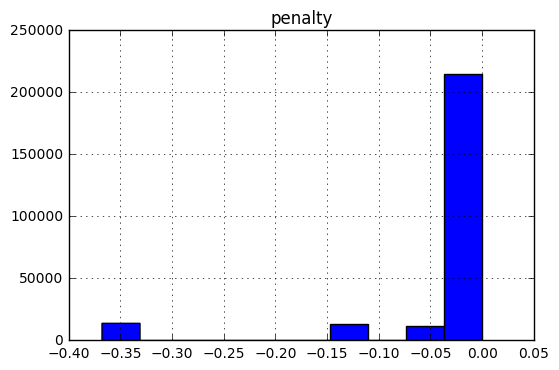

In [17]:
dfStats.hist('penalty');

In [18]:
dfStats['likelihood'] = dfStats['click_ratio'] + dfStats['penalty']

In [19]:
print('The maximum likelihood is {:.4f} and the minimum likelihood is {:.4f}'.format(
        dfStats['likelihood'].max(), dfStats['likelihood'].min()))

The maximum likelihood is 1.0000 and the minimum likelihood is 0.0017


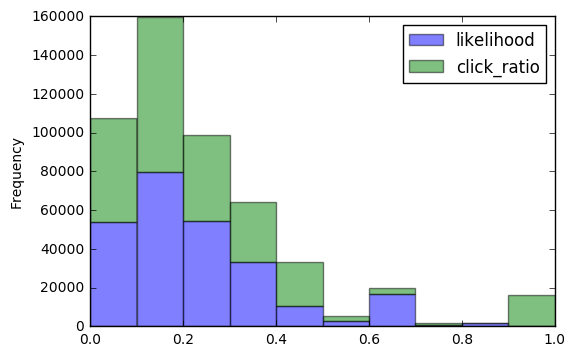

In [20]:
dfStats[['likelihood', 'click_ratio']].plot.hist(alpha=0.5, stacked=True);

## Save the order to file

In [21]:
dfStats = dfStats.sort_values('likelihood', ascending=False)

In [22]:
dfStats.tail(10)

,ad_id,clicks,views,click_ratio,penalty,likelihood
53417,96311,1,293,0.003413,-5.645687e-128,0.003413
49999,90162,1,295,0.003390,-7.640607e-129,0.003390
180035,380604,3,900,0.003333,-0.000000e+00,0.003333
50677,91417,4,1311,0.003051,-0.000000e+00,0.003051
145231,308515,1,340,0.002941,-2.187138e-148,0.002941
153175,326414,1,381,0.002625,-3.418239e-166,0.002625
110370,225013,4,1606,0.002491,-0.000000e+00,0.002491
138461,292592,1,441,0.002268,-2.993184e-192,0.002268
120786,251781,1,537,0.001862,-6.079435e-234,0.001862
154317,328678,1,599,0.001669,-7.204525e-261,0.001669


In [23]:
dfStats['ad_id'].to_csv(dataDir + "clickedOrder.csv", header=False, index=False)